In [2]:
%pylab inline --no-import-all
import seaborn as sns
import scipy as sp
import scipy.ndimage
import os
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras.datasets import mnist

Populating the interactive namespace from numpy and matplotlib


Load MNIST dataset and convert result to numpy arrays

In [70]:
(trainX, trainY), (testX, testY) = mnist.load_data()
train_samples = trainX.shape[0]
test_samples = testX.shape[0]

trainX = trainX.reshape((train_samples, 28*28)) / 255.0
testX = testX.reshape((test_samples, 28*28)) / 255.0
trainY = keras.utils.to_categorical(trainY, num_classes=10)

First let's create multiple layer perceptron

In [78]:
mlp_model = Sequential([
    Dense(64, input_shape=(784,), kernel_initializer='random_uniform'),
    Activation('relu'),
    Dropout(0.125),
    Dense(64, kernel_initializer='random_uniform'),
    Activation('relu'),
    Dense(10, kernel_initializer='random_uniform'),
    Activation('softmax'),
])

mlp_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Training the model

In [79]:
mlp_model.fit(trainX, trainY, epochs=10, batch_size=50)

Epoch 1/10
60000/60000 [==============================] - 3s - loss: 0.4456 - acc: 0.8670     
Epoch 2/10
60000/60000 [==============================] - 2s - loss: 0.2003 - acc: 0.9395     
Epoch 3/10
60000/60000 [==============================] - 2s - loss: 0.1499 - acc: 0.9542     
Epoch 4/10
60000/60000 [==============================] - 2s - loss: 0.1255 - acc: 0.9617     
Epoch 5/10
60000/60000 [==============================] - 2s - loss: 0.1101 - acc: 0.9658     
Epoch 6/10
60000/60000 [==============================] - 2s - loss: 0.0974 - acc: 0.9691     
Epoch 7/10
60000/60000 [==============================] - 2s - loss: 0.0885 - acc: 0.9719     
Epoch 8/10
60000/60000 [==============================] - 2s - loss: 0.0825 - acc: 0.9728     
Epoch 9/10
60000/60000 [==============================] - 2s - loss: 0.0768 - acc: 0.9753     
Epoch 10/10
60000/60000 [==============================] - 2s - loss: 0.0722 - acc: 0.9770     


Define some helper functions

In [80]:
def decode_one_hot(encoded):
    return np.apply_along_axis(np.argmax, axis=1, arr=encoded)

def evaluate_accuracy(predicted, expected): 
    return ("model accuracy on test data: {:.3f}%"
            .format(100 * (1.0 - (predicted != expected).sum() / expected.shape[0])) )

Predict output values for test samples and evaluate model accuracy

In [81]:
mlp_predictions = mlp_model.predict(testX)

decoded_mlp_predictions = decode_one_hot(mlp_predictions)
expected = testY.reshape(test_samples)

print(evaluate_accuracy(decoded_mlp_predictions, expected))

model accuracy on test data: 97.490%


Test error is almost equal, so this means that there's no overfitting.
Although 97.5% is not accurate enough, but isn't so bad for the first time

Now let's see how frequently certain digits were not recognized and what's was recognized instead 

In [82]:
import matplotlib.patches as mpatches

def error_plot(predictions, true):
    def what_is_predicted(predictions, instead_of):
        return predictions[np.all(
            (predictions != true, true == instead_of),
            axis=0)]

    fig, ax = plt.subplots(figsize=(14, 10), dpi=80)
    colors = [
        "#B76C6C",
        "#B78B6C",
        "#B3B76C",
        "#90B76C",
        "#6CB77E",
        "#6CB7B2",
        "#6C96B7",
        "#6C76B7",
        "#906CB7",
        "#B76CB5"
    ]
    plt.xticks(np.arange(10), size=16)
    plt.xlabel("What should be", size=20)
    plt.ylabel("Wrong predictions", size=20)


    wrong_numbers = [np.bincount(what_is_predicted(predictions, i)) for i in range(0, 10)]
    result = []
    for i, num in enumerate(wrong_numbers):
        bottom = 0
        for j, error in enumerate(num):
            if error:
                result.append(ax.bar(i, error, bottom=bottom, color=colors[j]))       
                ax.text(i, bottom + error*0.5 - 0.1, j,
                        verticalalignment='center',
                        horizontalalignment='center',
                        size=10, weight='bold')

                bottom += error

    ax.legend(handles = [mpatches.Patch(color=colors[i], label=i) for i in reversed(range(10))])

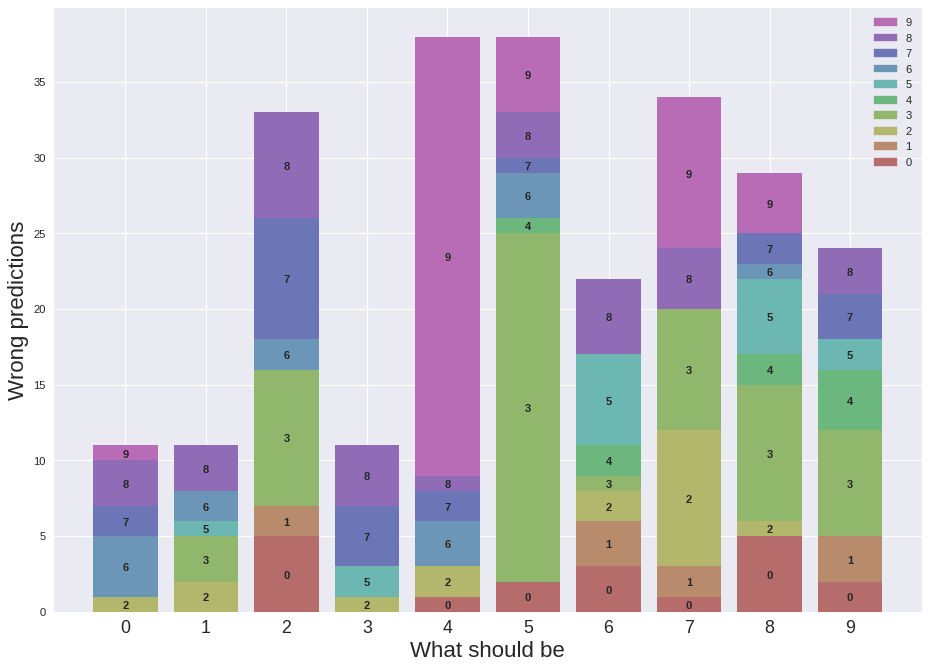

In [83]:
error_plot(decoded_mlp_predictions, expected)

From this chart we can see, that the most frequent errors are:
<ul>
<li>9 instead of 4</li>
<li>3 instead of 5</li>
</ul>

Now we're going to create more complex network, with two convolution layers. Convolution neural networks are slower, but are much more efficient on image recognition

In [84]:
cnn_model = Sequential([
    # input shape is (28, 28, 1), i.e. 28x28 pixels image with 1 color chanel (grayscale)
    
    # first convolution layer with 3x3 filters for extracting micro features
    Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.05),
    
    # second convolution layer with 5x5 filters for extracting macro features
    Conv2D(128, (3, 3), activation='relu', strides=(2,2)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.1),
    
    Flatten(),
    Dense(128, activation='relu', kernel_initializer='random_uniform'),
    Dropout(0.5),
    Dense(10, activation='softmax', kernel_initializer='random_uniform')
])

cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In order to apply 2D convolution, we have to convert our train samples into (28, 28, 1) tensors

In [85]:
cnnTrainX = trainX.reshape(train_samples, 28, 28, 1)
cnnTestX = testX.reshape(test_samples, 28, 28, 1)

In [86]:
cnn_model.fit(cnnTrainX, trainY, batch_size=50, epochs=10)

Epoch 1/10
60000/60000 [==============================] - 54s - loss: 0.3270 - acc: 0.8968    
Epoch 2/10
60000/60000 [==============================] - 55s - loss: 0.1250 - acc: 0.9623    
Epoch 3/10
60000/60000 [==============================] - 54s - loss: 0.0956 - acc: 0.9705    
Epoch 4/10
60000/60000 [==============================] - 51s - loss: 0.0764 - acc: 0.9772    
Epoch 5/10
60000/60000 [==============================] - 50s - loss: 0.0673 - acc: 0.9797    
Epoch 6/10
60000/60000 [==============================] - 52s - loss: 0.0578 - acc: 0.9825    
Epoch 7/10
60000/60000 [==============================] - 51s - loss: 0.0518 - acc: 0.9837    
Epoch 8/10
60000/60000 [==============================] - 50s - loss: 0.0477 - acc: 0.9852    
Epoch 9/10
60000/60000 [==============================] - 50s - loss: 0.0445 - acc: 0.9863    
Epoch 10/10
60000/60000 [==============================] - 50s - loss: 0.0396 - acc: 0.9873    


Evaluating on test data

In [87]:
cnn_predictions = cnn_model.predict(cnnTestX)

decoded_cnn_predictions = decode_one_hot(cnn_predictions)
expected = testY.reshape(testY.shape[0])

print(evaluate_accuracy(decoded_cnn_predictions, expected))

model accuracy on test data: 99.140%


99.14% is significantly better result. It could come from CNN's ability to recognize spatial structure of images

Let's take a look at errors details

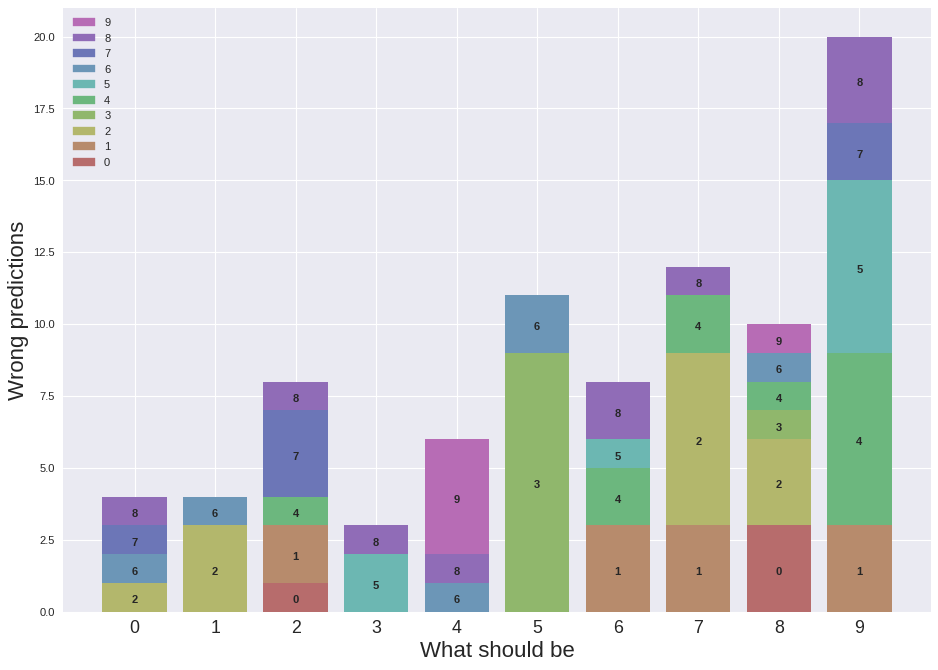

In [88]:
error_plot(decoded_cnn_predictions, expected)

Typical errors are:
* 5 instead of 3
* 9 instead of 4
* 4 and 5instead of 9